__<center>3º Deliverable: Machine Learning</center>__

__<center>Life insurance policy</center>__

<div>
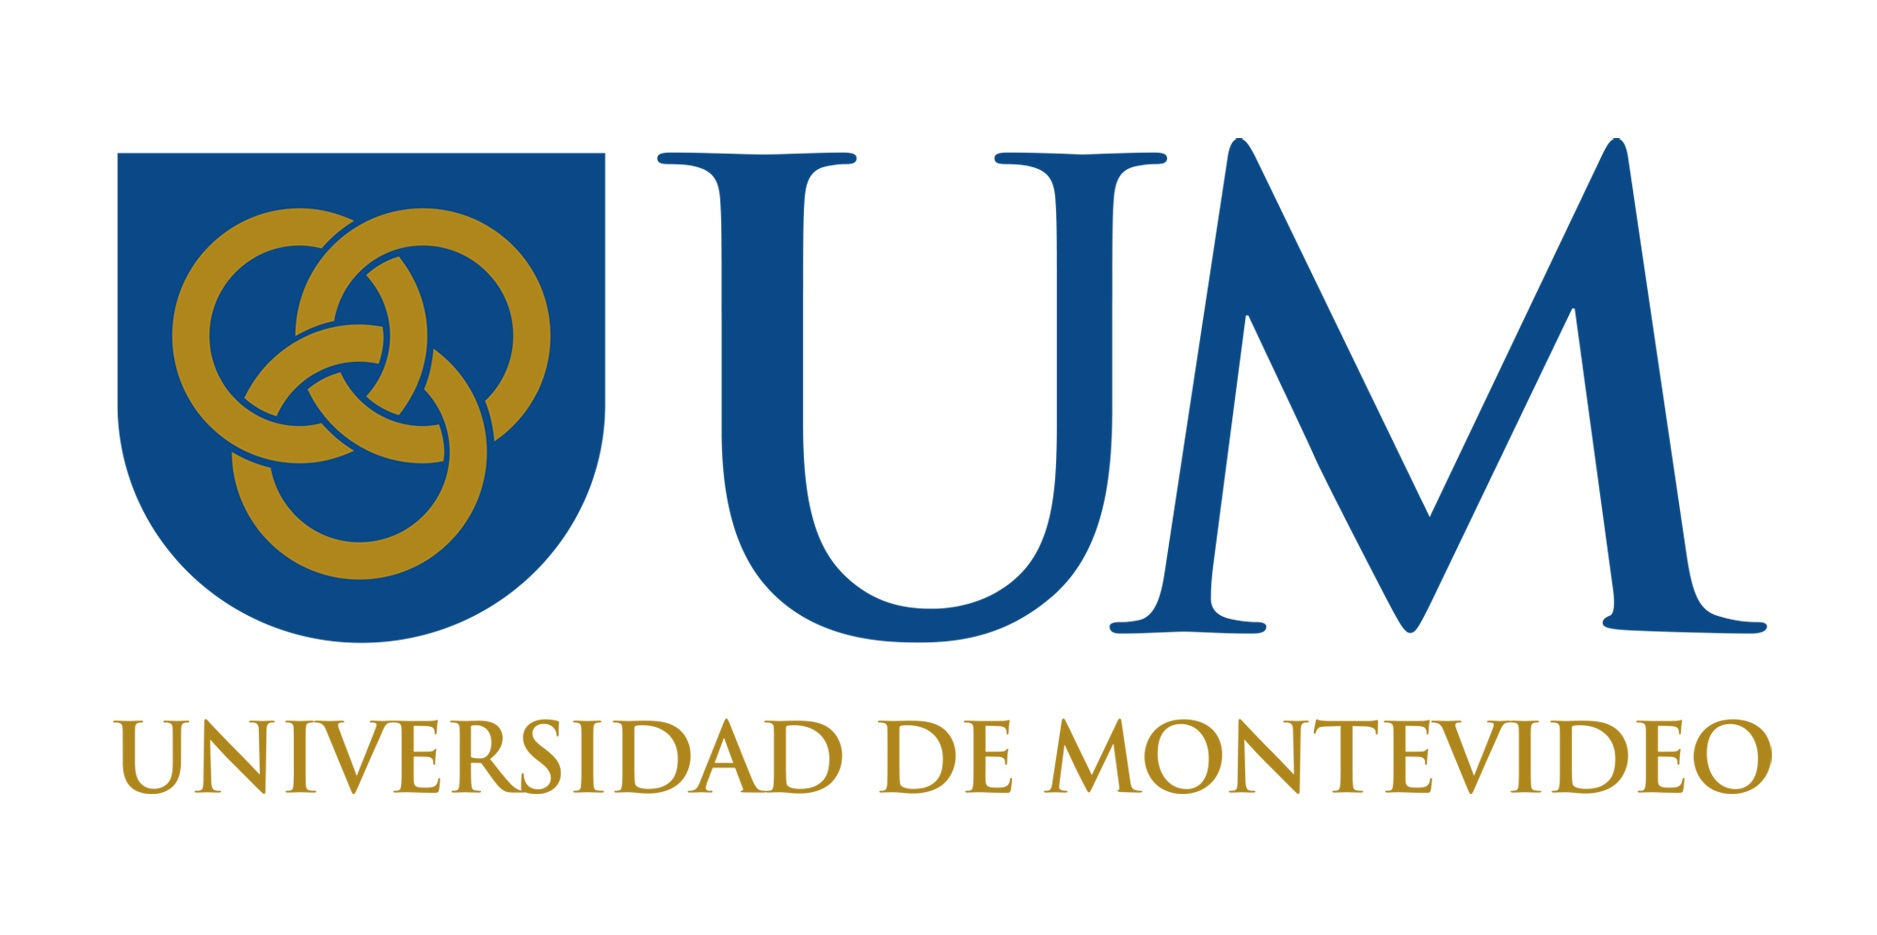
</div>


<center>Team VIII: Ariel Mordetzki and Mateo Stipaničić</center>
<center>Prof. Sebastián García Parra</center>
<center>November 2022</center>

___


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outline" data-toc-modified-id="Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outline</a></span></li><li><span><a href="#Registration-form" data-toc-modified-id="Registration-form-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Registration form</a></span><ul class="toc-item"><li><span><a href="#Synthetic-dataset-creation" data-toc-modified-id="Synthetic-dataset-creation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Synthetic dataset creation</a></span></li><li><span><a href="#Clustering-model" data-toc-modified-id="Clustering-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clustering model</a></span></li><li><span><a href="#Classification-model" data-toc-modified-id="Classification-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Classification model</a></span></li></ul></li><li><span><a href="#Clinical-records-information" data-toc-modified-id="Clinical-records-information-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clinical records information</a></span><ul class="toc-item"><li><span><a href="#Data-analysis-on-clinical-records-dataset" data-toc-modified-id="Data-analysis-on-clinical-records-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data analysis on clinical records dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset-configuration" data-toc-modified-id="Dataset-configuration-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Dataset configuration</a></span></li><li><span><a href="#Data-cleaning-and-pre-processing" data-toc-modified-id="Data-cleaning-and-pre-processing-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Data cleaning and pre-processing</a></span></li><li><span><a href="#Dataset-discussion" data-toc-modified-id="Dataset-discussion-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Dataset discussion</a></span></li></ul></li><li><span><a href="#Key-clinical-variables" data-toc-modified-id="Key-clinical-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Key clinical variables</a></span><ul class="toc-item"><li><span><a href="#Decision-tree-for-variable-identification" data-toc-modified-id="Decision-tree-for-variable-identification-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Decision tree for variable identification</a></span></li></ul></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random forest</a></span></li></ul></li></ul></div>



___

# Outline

The following is a commented code in Python that corresponds to the third task in Universidad de Montevideo's Machine Learning course. 

> __Context__ A life insurance carrier is wondering whether revenue could be increased, given the fact that, apparently, they have wrongly denied insurances to some clients.

> __Objectives__  The scope is dual: _(1)_ create a model that predicts whether additional information such as clinical records should be asked to an incoming client and _(2)_ create a model that identifies whether those given records signify a heart failure threat. The first one can be, too, divided in two: _(1.1)_ from the universe of past people who have asked a life insurance, what's the sub-group that should have been asked further information, instead of rejecting them and _(1.2)_ ponder if an incoming client belongs to such sub-group.

> __Problem definition__ Question _(1.1)_ is modelled as a clustering problem due to the lack of target labels <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1); _(1.2)_ as a classification problem with the former problem's clusters as classes; _(2)_ as a classification problem as well. 

> __Method__ k-means is used as clustering model for _(1.1)_, whereas a decision tree is implemented in _(1.2)_ and a random forest for _(2)_.


This approach takes an important assumption, that is, it is preferable to ask an incoming client his clinical records when it was not needed, and then correctly classify him as dangerous or not (in this way, there are two barriers to be skipped). In other words, both in problem _(1)_ and _(2)_ we try to avoid as much false positives <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-1) as possible (no incoming client with high risk of heart failure should be welcomed) but simultaneously, prevent the loss of clients, so in problem _(2)_,  there is also a vested interest in lowering false negatives as well.

The reasoning of this logic resides on the fact that a false negative means an operational cost, whereas a false positive implies "just" an opportunity cost (although it is true that these opportunity costs are the ones being searched for).


_Notes:_

<a name="cite_note-1"></a> [1](#cite_ref-1) The past data on whether the client was accepted or not could be interpreted as a label, or even heart failure history. However, we understand that if the insurance carrier is attempting to renew its client policy, it is only fair to construct the new labelling from the client universe's proper patterns, and not from the same policy that is wished to change.

<a name="cite_note-2"></a> [2](#cite_ref-2) Positive meaning no clinical record request or no heart failure risk, implying a "good" client (a false positive is thus someone who was labelled as a solid client, but in fact he was not). Instead, a false negative would be a client discarded that had no risk at all. The terms positive and negative could be interpreted conversely, but the idea is to strictly minimize the amount of clients at risk, and if possible, maximize healthy clients.

In [68]:
# Imports used in this Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
from scipy import stats

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

___
# Registration form

> In this section, we will explore problems _(1.1)_ and _(1.2)_, meaning, the clustering and classification of answers in the registration form.

## Synthetic dataset creation

We found that scikit-learn has implemented a dataset generator, having as input the probability distributions of each feature. The attributes for each sample must be related to the questions in the registration form: 
- Weight (float) 
- Height (float)
- Number of sports practiced (int)
- Smoker (bool)
- Risky activity (bool)
- Hipertension (bool)
- Diseases (bool)
- Treatments (bool)

## Clustering model

## Classification model

___
# Clinical records information

> We now turn into problem _(2)_, which aims to identify key patterns in a clinical records dataset as to create a predictive model over incoming clients' clinical information; the objective is to identify heart failure risk. __We perform both a decision tree and a random forest as to understand which health variables are to be asked; then, we make use of these decision tree and random forest as to perform the classification model.__


## Data analysis on clinical records dataset

### Dataset configuration

In [69]:
# Dataset
dataset_blood = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Variable identification: dataset format with first sample bloodtests
dataset_blood.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


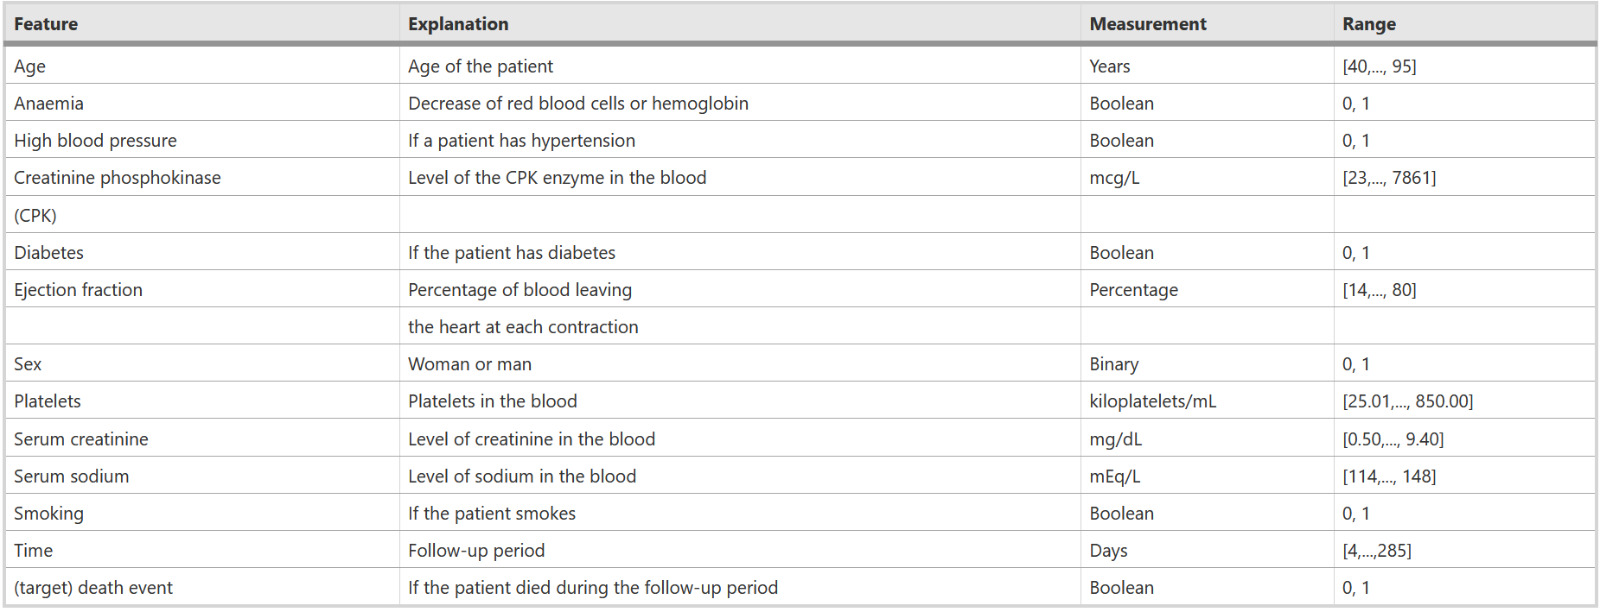

In [70]:
# Print dataset size
dataset_blood.shape

(299, 13)

In [71]:
# Data types and null counts
dataset_blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


It should be noted how non-null counts are all equal to the amount of samples in the dataset: there are no null values.

In [72]:
# Statistical properties
dataset_blood.describe(percentiles = [0.25, 0.50, 0.75, 0.95])

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
95%,82.000000,1.000000,2263.000000,1.000000,60.000000,1.000000,422500.000000,3.00000,144.000000,1.000000,1.00000,250.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


This presentation of statistical properties indicates the need for outlier considerations: for example, the maximum value in _creatinine_phosphokinase_ is too high compared to the mean, the standard deviation and the 95% percentile. The same happens with _platelets_ and _serum_creatinine_.

### Data cleaning and pre-processing

In [73]:
# Cleaning unwanted features
dataset_blood.drop('time', axis=1, inplace=True)
dataset_blood.shape

(299, 12)

Given a description of all variables, we understand that the feature _Time_ is not relevant for the analysis; we were not going to consider cases where follow-up period is either too short or too long, but dataset was drastically reduced and those extreme situations carried information (for example, short follow-ups coincided with death event, and viceversa).

In [74]:
# Confirmation on null counts
dataset_blood.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
DEATH_EVENT                 0
dtype: int64

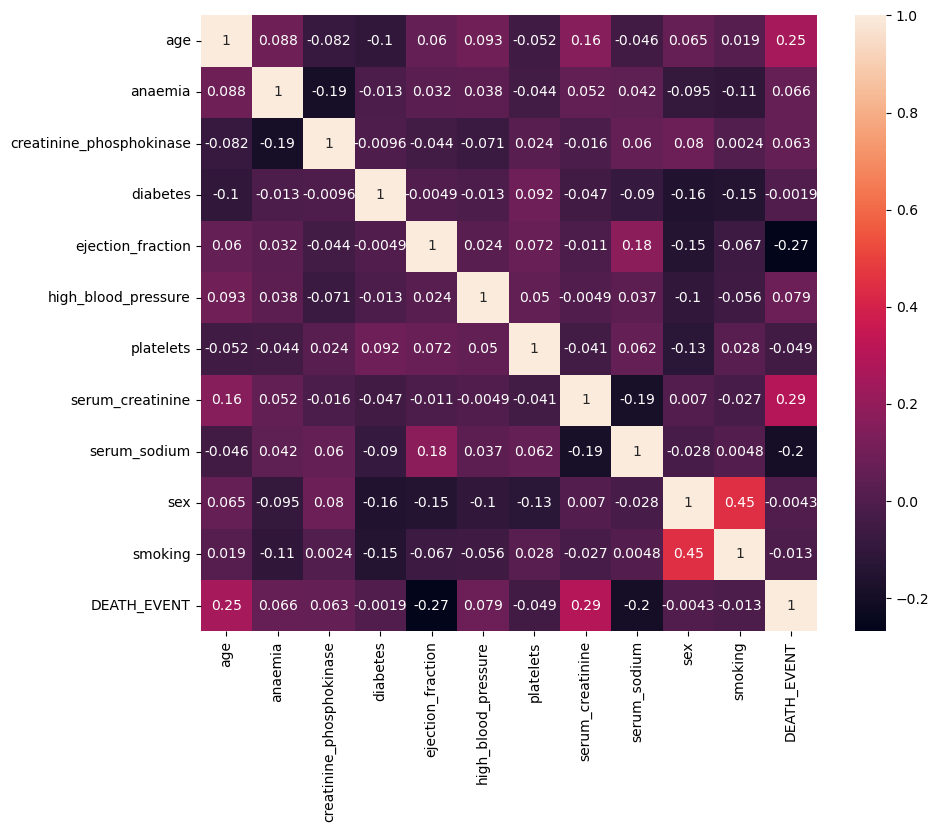

In [75]:
# Observing relationships between variables
f, ax = plt.subplots(figsize=(10, 8))
correlation = dataset_blood.corr()
sns.heatmap(correlation, mask=np.zeros_like(correlation, dtype=bool), square=True, ax=ax, annot=True)
plt.show()

Variables do not seem to be highly correlated between each other: the maximum correlation, in absolute value, is 0.5. This suggests that the feature combinations do not overlap (each feature would add valuable information), possibly implying a low degree of reduction in explained variance in a PCA analysis.

Text(0, 0.5, 'Cumulative Explained Variance')

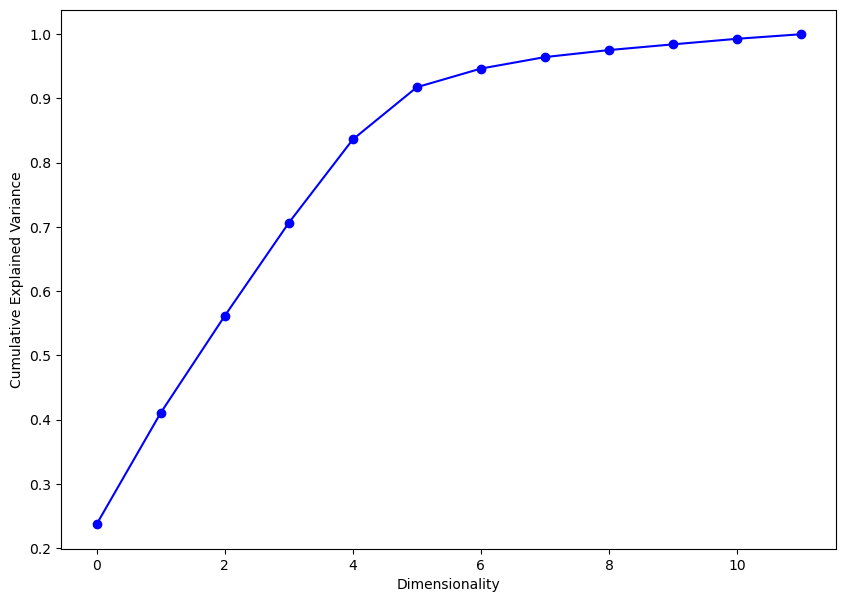

In [76]:
# Explained variance reducing dimensionality
scaler = MinMaxScaler() 
dataset_blood_scaled = pd.DataFrame(scaler.fit_transform(dataset_blood), columns = dataset_blood.columns)

pca = PCA()
pca.fit(dataset_blood_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Dimensionality')
plt.ylabel('Cumulative Explained Variance')

The assumption derived from the correlation matrix turned out to be rather untrue, given the fact that a 6-dimensional space would explain 95% of variance. This could be understood by the fact that the correlation matrix does not include correlation between combinations of variables. Nevertheless, __we will not perform PCA since we want to maintain the white-box nature of the modelling__ and maneuver variables with clinical sense.

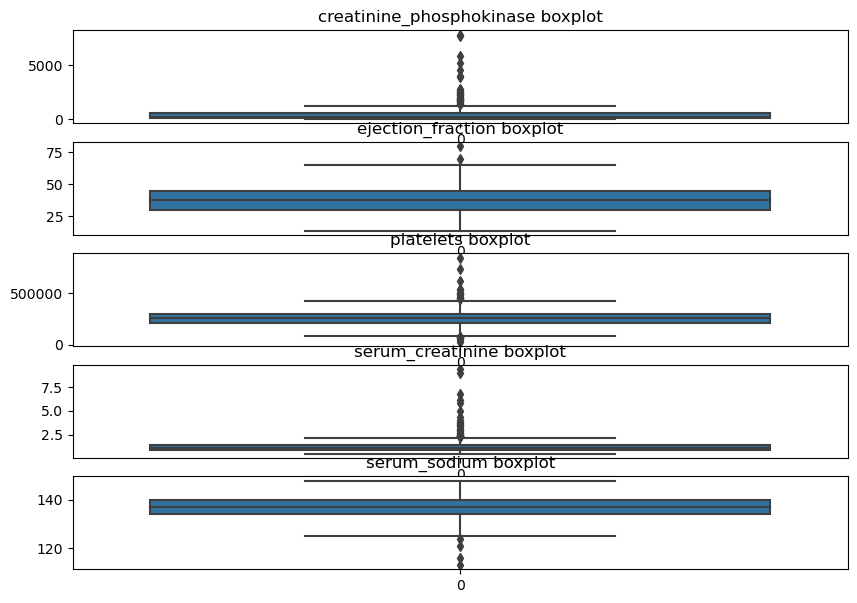

In [77]:
# Boxplots for outlier identification in relevant columns
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
sns.boxplot(dataset_blood['creatinine_phosphokinase'], ax=ax1)
ax1.title.set_text('creatinine_phosphokinase boxplot')
sns.boxplot(dataset_blood['ejection_fraction'], ax=ax2)
ax2.title.set_text('ejection_fraction boxplot')
sns.boxplot(dataset_blood['platelets'], ax=ax3)
ax3.title.set_text('platelets boxplot')
sns.boxplot(dataset_blood['serum_creatinine'], ax=ax4)
ax4.title.set_text('serum_creatinine boxplot')
sns.boxplot(dataset_blood['serum_sodium'], ax=ax5)
ax5.title.set_text('serum_sodium boxplot')
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams['figure.figsize'] = 8, 15

We search for outliers in columns that seem relevant when looking at the dataframe.describe() method. We can observe the high degree of outliers; thus, we take a brute force approach (instead of finger-picking outliers), and take out outliers with the traditional definition of samples 3 or more times the standard deviations far from the mean.

In [78]:
# Outlier considerations
dataset_blood = dataset_blood[(np.abs(stats.zscore(dataset_blood)) < 3).all(axis=1)]
dataset_blood.shape

(280, 12)

### Dataset discussion

In order to analyze the dataset's properties, we will frame the discussion into categories:
- __Volume:__ Interestingly enough, one would think that more data is available for such a relevant topic. However, it is understood that 
- __Velocity:__ This aspect is not of interest in this deliverable (we are __not__ getting data faster than we can process it).
- __Variety:__ The high degree of outliers can in fact be proof of the varied nature of the dataset.
- __Veracity:__ Lack of null values and lack of incoherent data samples makes a good case for this dataset's veracity.
- __Value:__ The business value of the dataset is framed in the insurance client policy system, although its scope reaches far from this application only.

## Key clinical variables

> We will try to identify the most important features that determine the risk of heart failure.

In [79]:
# Trees and forests require scaled dataset given the use of Euclidean distance
scaler = MinMaxScaler() 
dataset_blood_scaled = pd.DataFrame(scaler.fit_transform(dataset_blood), columns = dataset_blood.columns)

In [80]:
# Train and test split
X = dataset_blood_scaled.loc[:,dataset_blood_scaled.columns != 'DEATH_EVENT'] # features
y = dataset_blood_scaled ['DEATH_EVENT'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

### Decision tree for variable identification

In [81]:
def plotDephtAccuracy():
    
    max_depth=range(1,20)
    training_accuracy = [] 
    test_accuracy = []
    training_f1 = []
    test_f1 = []

    for depth in max_depth : 
            
        tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=1).fit(X_train, y_train)
     
        y_train_pred = tree.predict(X_train)
        y_pred = tree.predict(X_test)
    
        training_accuracy.append(accuracy_score(y_train,y_train_pred))
        test_accuracy.append(accuracy_score(y_test, y_pred))
    
        training_f1.append(f1_score(y_train,y_train_pred))
        test_f1.append(f1_score(y_test, y_pred))
        
    fig = plt.figure(figsize=(14,10))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    fig.add_subplot(2,2,1)
    plt.plot(max_depth, training_accuracy, label='training accuracy')
    plt.plot(max_depth, test_accuracy, label='test accuracy')
    plt.ylabel('Accuracy',size=20)
    plt.xlabel('Max depth',size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.title('Accuracy Score',size=20, weight='bold')
    plt.legend(['Training','Testing'],frameon=False)
    plt.show()    

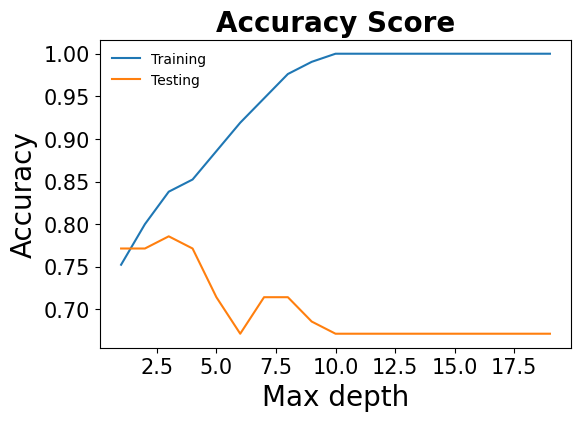

In [82]:
# Plot accuracy score for different tree depths
plotDephtAccuracy()

As espected, the accuracy of training quickly tends to $1$ as the max depth increases. This is due to the very definition of overfitting a tree. We see a maximum of accuracy on training to max depth = 3



In [83]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=0).fit(X_train, y_train)
y_pred=tree.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))

Accuracy on test: 0.786


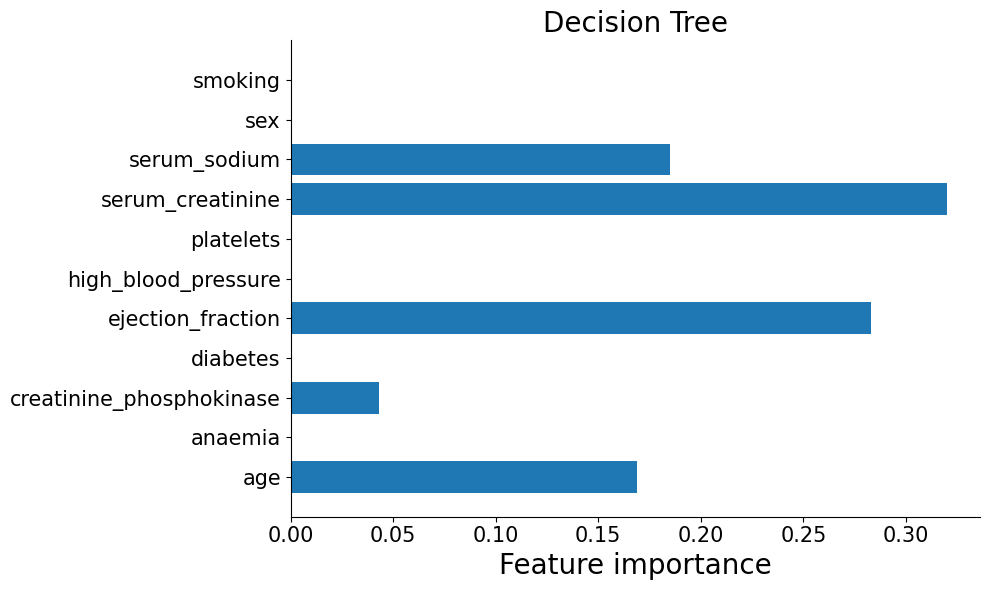

In [84]:
def plot_feature_importances(model, figure):
    

    n_features = len(X.columns) # number of features
    plt.figure(figsize=(10,6))
    plt.barh(range(n_features), model.feature_importances_, align='center') # check documentation on model
    plt.yticks(np.arange(n_features), X,size=15)
    plt.xticks(size=15)
    plt.xlabel('Feature importance',size=20,)
    #plt.ylabel('Feature',size=20)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f'{figure}',size=20)
    plt.tight_layout()

plot_feature_importances(tree,'Decision Tree')

We shall repeat this process using random forest, in order to analyze more extensively

## Random forest


In [85]:
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred=rf.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))


Accuracy on test: 0.800


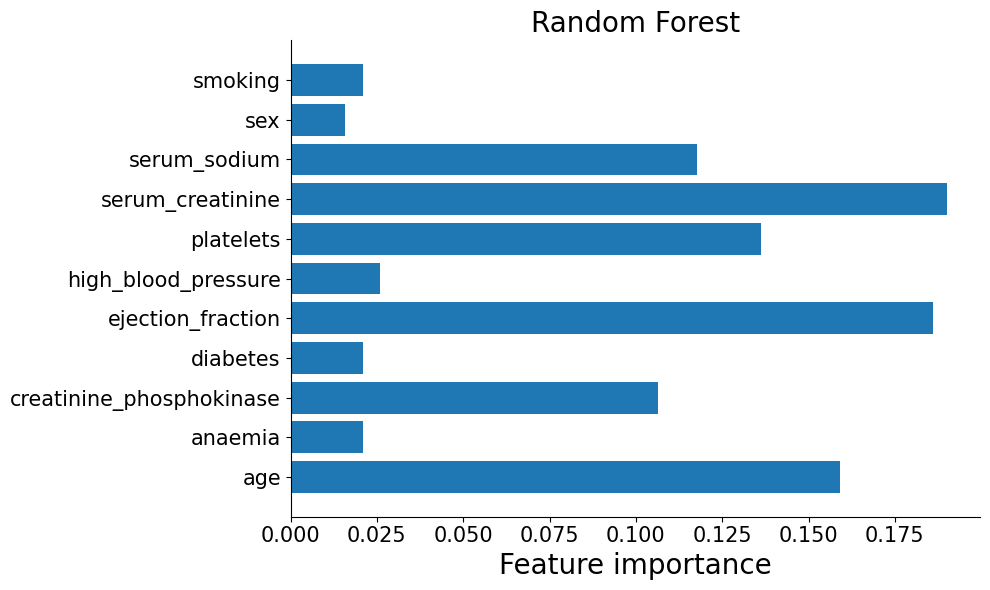

In [86]:
plot_feature_importances(rf, 'Random Forest')

Both models give similar results on feature importance, but as espected, random forest gives more insight. 

As we can see, the most important features are:
> * serum_creatinine
> * ejection_fraction
> * creatinine_phosphokinase
> * age
> * platelets


# fake data

In [87]:
size = 1000
columns = ["weight", "height", "number_of_sports", "smoker", "risk_activity", "hipertension", "diseases", "treatements"]
weights = np.random.normal(75, 25, size) #in kg
heights = np.random.normal(170, 15, size) # in cm
n_of_sports = np.random.randint(0, 3,size )
smoker = np.random.randint(0, 1, size)
risk_activity = np.random.randint(0, 1, size)
hiper = np.random.randint(0, 1, size)
treatments = np.round_(np.random.exponential(scale=1.0, size = size))
diseases = np.round_(np.random.exponential(scale=1.0, size=size))


data = dict(zip(columns, [weights, heights, n_of_sports, smoker, risk_activity, hiper, diseases,treatments]))
df = pd.DataFrame(data)
df.head()

,weight,height,number_of_sports,smoker,risk_activity,hipertension,diseases,treatements
0,33.824861,165.476846,2,0,0,0,0.0,0.0
1,94.191504,139.303462,2,0,0,0,1.0,2.0
2,67.758303,140.312676,0,0,0,0,0.0,1.0
3,120.933647,179.772459,0,0,0,0,1.0,2.0
4,81.830847,155.429165,2,0,0,0,0.0,1.0


C:\Users\Ariel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ariel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ariel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ariel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

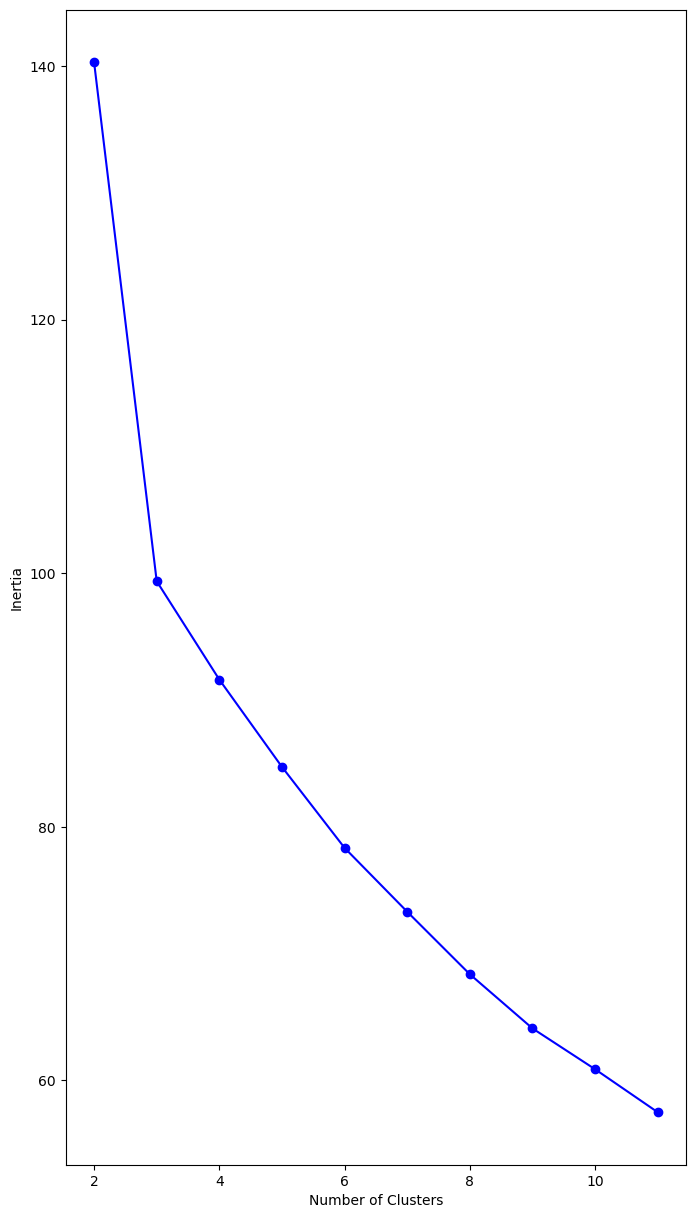

In [88]:

def elbobMethod(max_clusters, dataset):
    from sklearn.cluster import KMeans
    # Elbow method

    elbow_points = []
    #max_clusters = len(dataset_blood_scaled)
    n_clust = [i+2 for i in range(max_clusters)]

    for num in n_clust:
        kmeans = KMeans(n_clusters = num, random_state = 42)
        kmeans.fit(dataset)
        elbow_points.append(kmeans.inertia_)

    plt.plot(n_clust, elbow_points, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()


max_clusters = 10

scaler = MinMaxScaler() 
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)


elbobMethod(max_clusters, df_scaled)

In [89]:
def nClusters(n, dataset):
    
    # DESCRIPTION: 
    # Function that clusterizes some dataset.
    
    # INPUTS:
    # n (int): Number of clusters
    # dataset (pd Dataframe): Clients dataset after a PCA for dimensionality reduction
    # modelType (str): string indicating the choice of model
    
    # OUTPUTS:
    # model (object): the sklearn model of kmeans already "trained", used for
    # obtaining information
    # dataset (pd dataframe): the fitted dataset
    # clusters_df (pandas dataframe): the input dataframe but with cluster id aggregated
    # assign (pandas dataframe): the original first dataframe with original features,
    # but with cluster id aggregated
    
    model = KMeans(n_clusters = n, random_state = 42) # max iters is set to 300 by default
    model.fit(dataset)

    # Assign a cluster id to the original df.
    clusters_df = pd.concat([dataset, pd.Series(model.labels_)], axis = 1) # concatenate labels to pca df
    clusters_df.columns = np.concatenate((dataset.columns.values, ['CLUSTER ID']), axis = 0) #add the "cluster id" columna
    #clusters_df = pd.concat([CUST_ID, clusters_df], axis = 1) #add the "customer id" df at the begining.
    print(f'The model assigned theese values:')
        
    # Recovering previous features for discussion:
    #assign = pd.concat([client_data, pd.Series(model.labels_)], axis = 1) # concatenate labels to pca df
    #assign.columns  = np.concatenate((client_data.columns.values, ['CLUSTER ID']), axis = 0) #add the "cluster id" columna
    print(clusters_df['CLUSTER ID'].value_counts())
        
    return clusters_df, model

n = 3

df_scaled_cluster, model = nClusters(n, df_scaled)

The model assigned theese values:
2    345
0    343
1    312
Name: CLUSTER ID, dtype: int64


C:\Users\Ariel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [90]:
df_scaled_cluster

,weight,height,number_of_sports,smoker,risk_activity,hipertension,diseases,treatements,CLUSTER ID
0,0.237548,0.440461,1.0,0.0,0.0,0.0,0.000000,0.000,2
1,0.653086,0.147372,1.0,0.0,0.0,0.0,0.142857,0.250,2
2,0.471131,0.158673,0.0,0.0,0.0,0.0,0.000000,0.125,0
3,0.837167,0.600543,0.0,0.0,0.0,0.0,0.142857,0.250,0
4,0.568000,0.327947,1.0,0.0,0.0,0.0,0.000000,0.125,2
...,...,...,...,...,...,...,...,...,...
995,0.469588,0.375084,1.0,0.0,0.0,0.0,0.142857,0.125,2
996,0.454836,0.578735,0.5,0.0,0.0,0.0,0.285714,0.250,1
997,0.283898,0.661303,0.0,0.0,0.0,0.0,0.000000,0.000,0
998,0.574404,0.710460,1.0,0.0,0.0,0.0,0.142857,0.000,2


In [91]:
def plotNdimensions(n,n_clusters, dataset,model, model_type): 
    
    # DESCRIPTION:
    # Function that given a fitted dataset, plots the clustering result
    # in order to do this, we perform a PCA to reduce dimensionality.
    
    # INPUTS:
    # n (int): number of dimensions to plot (number of components of visualization PCA)
    # dataset (sklearn object): ALREADY fitted dataset of 6 components
    # model (sklearn object): model type, only used to get labels for plot
    # model_type (str): string indicating the model type,
    # only used for fancy automatic titles
    
    # OUTPUTS:
    # No outputs
    
    plt.rcParams['figure.figsize'] = [10, 7]
    
    # pca to lower dimension to n
    n_components = n
    pca_final = PCA(n_components = n_components)
    pca_final.fit(dataset)  
    
    # aux df for plotting
    visualization = pd.DataFrame(pca_final.fit_transform(dataset), columns = [str(i) for i in range(n)])
    visualization = pd.concat([visualization, pd.Series(model.labels_)], axis = 1) # add the labels
    visualization.columns = np.concatenate(([str(i+1) for i in range(n)],['CLUSTER ID']), axis = 0)   
    
    if n == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        x = visualization['1'].values.astype(float)
        y = visualization['2'].values.astype(float)
        z = visualization['3'].values.astype(float)

        ax.scatter(x,y,z, c=visualization["CLUSTER ID"], s=40) #, cmap="RdBu")
        
        plt.title(f'3D visualization for: {n_clusters} clusters, using: {model_type} clustering')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        
        ax.set_xlabel('PC1', fontweight ='bold')
        ax.set_ylabel('PC2', fontweight ='bold')
        ax.set_zlabel('PC3', fontweight ='bold')
      
        plt.show()
    
    elif n == 2:
        
        sns.scatterplot(x='1',y='2',hue='CLUSTER ID',legend='full',data=visualization).set(title=f'2D visualization for: {n_clusters} clusters, using: {model_type} clustering')

    else:
        print("The human brain can only interpret 2 or 3 dimensions")
        
        

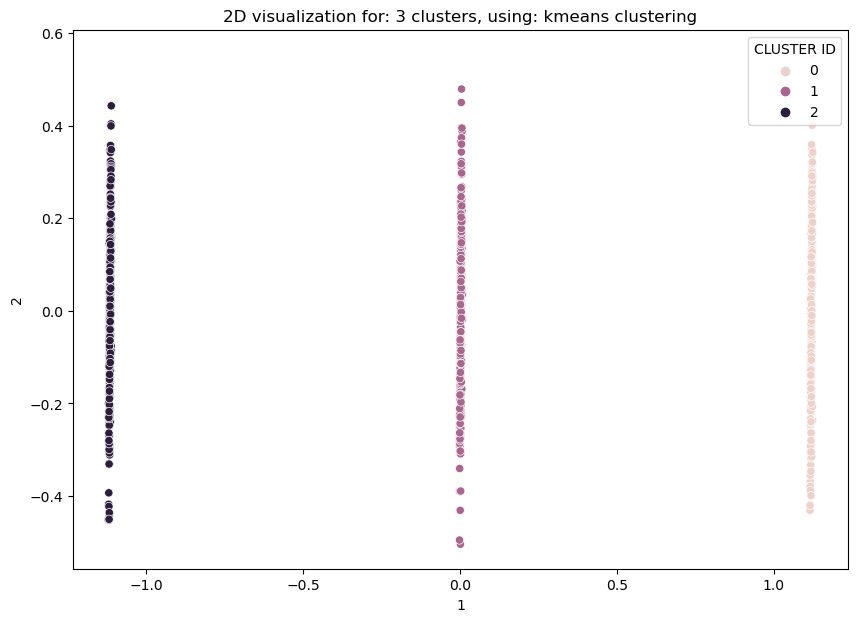

In [92]:
dimensions = 2
plotNdimensions(dimensions,n, df_scaled_cluster,model, 'kmeans')

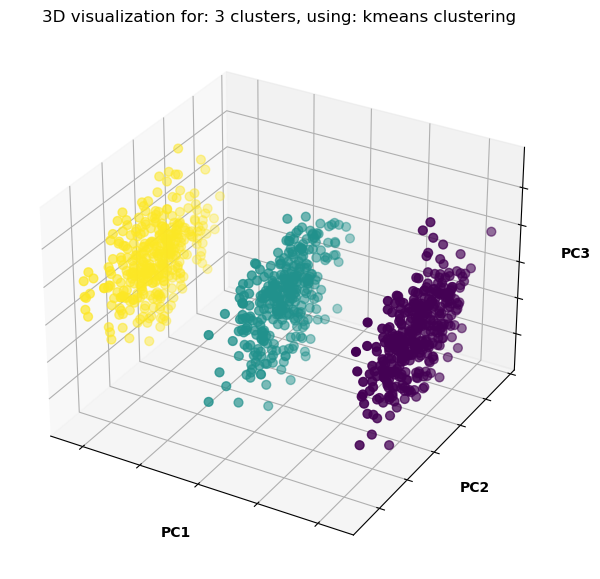

In [93]:
dimensions = 3
plotNdimensions(dimensions,n, df_scaled_cluster,model, 'kmeans')

In [94]:


def getMeansFromCluster(assigned_df, n_clusters):
    
    # DESCRIPTION:
    # Function that outputs statistics of dataset with assigned cluster id
    # after some clusterization
    
    # INPUTS:
    # assigned_df (pandas dataframe): dataframe containinng the original
    # features before pca and a cluster id
    # n_clusters (int): number of clusters 
    
    # OUTPUTS:
    # statistics (pandas dataframe): dataframe containing the mean of
    # every feature grouped by cluster
    
    # HAY QUE CAMBIAR ESTO
    #["weight", "height", "number of sports", "smoker", "risk activity", "hipertension", "diseases", "treatements"]
    
    weight = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).weight.mean())
    height= pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).height.mean())
    sports= pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).number_of_sports.mean())
    smoker = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).smoker.mean())
    risk_activity = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).risk_activity.mean())
    hipertension = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).hipertension.mean())
    diseases = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).diseases.mean())
    treatements = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).treatements.mean()) 
    

    statistics = pd.concat([pd.Series([i for i in range(n_clusters)]), weight,height, sports, smoker,risk_activity,hipertension,diseases,treatements], axis=1)
    statistics = statistics.rename(columns = {0:'CLUSTER ID'}) #correct the number of cluster id column
    return statistics


statistics = getMeansFromCluster(df_scaled_cluster, 3)
statistics

,CLUSTER ID,weight,height,number_of_sports,smoker,risk_activity,hipertension,diseases,treatements
0,0,0.505455,0.491008,0.0,0.0,0.0,0.0,0.142857,0.119898
1,1,0.495572,0.484100,0.5,0.0,0.0,0.0,0.124084,0.114183
2,2,0.523686,0.487566,1.0,0.0,0.0,0.0,0.147412,0.105072


In [95]:
# elegimos arbitrariamente el 0

df_to_further = df_scaled_cluster[df_scaled_cluster['CLUSTER ID'] == 0] # a estos les pedimos que se saquen sangre
df_to_further.head()

,weight,height,number_of_sports,smoker,risk_activity,hipertension,diseases,treatements,CLUSTER ID
2,0.471131,0.158673,0.0,0.0,0.0,0.0,0.000000,0.125,0
3,0.837167,0.600543,0.0,0.0,0.0,0.0,0.142857,0.250,0
5,0.479798,0.569492,0.0,0.0,0.0,0.0,0.000000,0.250,0
7,0.561874,0.590129,0.0,0.0,0.0,0.0,0.000000,0.000,0
12,0.554638,0.467501,0.0,0.0,0.0,0.0,0.000000,0.375,0


In [96]:
print("cantidad de personas a las que les pedimos analisis extra: ",len(df_to_further))

cantidad de personas a las que les pedimos analisis extra:  343
